## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1
bias = 1 

In [4]:
# Parameters
variance = 0.01
bias = 0.1


## Dataset 


In [5]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [6]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

          X1           X2        X3         X4         Y
0  51.416086  1637.326628  0.428870   9.941314  1.704159
1  92.785849   568.707928  0.862842  10.115126  1.442912
2  12.352336  1406.368867  0.987936   4.666535  1.611667
3  41.299539  1257.743037  0.709970   6.467194  1.544410
4  60.583667   244.833694  0.815585   2.011073  1.394679


In [7]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [8]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [9]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.027471
0:	learn: 0.9597271	total: 53.9ms	remaining: 53.8s
1:	learn: 0.9507801	total: 54.6ms	remaining: 27.3s
2:	learn: 0.9411842	total: 55.5ms	remaining: 18.4s
3:	learn: 0.9303629	total: 56.2ms	remaining: 14s
4:	learn: 0.9211686	total: 56.7ms	remaining: 11.3s
5:	learn: 0.9117420	total: 57.3ms	remaining: 9.5s
6:	learn: 0.8996683	total: 57.9ms	remaining: 8.21s
7:	learn: 0.8888769	total: 58.4ms	remaining: 7.24s
8:	learn: 0.8801802	total: 58.9ms	remaining: 6.48s
9:	learn: 0.8689142	total: 59.7ms	remaining: 5.91s
10:	learn: 0.8582533	total: 60.3ms	remaining: 5.42s
11:	learn: 0.8494786	total: 60.9ms	remaining: 5.01s
12:	learn: 0.8400068	total: 61.9ms	remaining: 4.7s
13:	learn: 0.8323482	total: 62.4ms	remaining: 4.4s
14:	learn: 0.8237934	total: 63ms	remaining: 4.13s
15:	learn: 0.8154260	total: 63.5ms	remaining: 3.9s
16:	learn: 0.8070123	total: 64.1ms	remaining: 3.7s
17:	learn: 0.7966290	total: 64.6ms	remaining: 3.52s
18:	learn: 0.7903163	total: 65.1ms	remaining: 3.36s
1

64:	learn: 0.5115125	total: 102ms	remaining: 1.47s
65:	learn: 0.5075626	total: 104ms	remaining: 1.47s
66:	learn: 0.5034743	total: 104ms	remaining: 1.46s
67:	learn: 0.4992595	total: 105ms	remaining: 1.44s
68:	learn: 0.4951055	total: 106ms	remaining: 1.43s
69:	learn: 0.4911881	total: 107ms	remaining: 1.42s
70:	learn: 0.4873572	total: 108ms	remaining: 1.41s
71:	learn: 0.4833942	total: 108ms	remaining: 1.4s
72:	learn: 0.4796295	total: 110ms	remaining: 1.39s
73:	learn: 0.4755145	total: 112ms	remaining: 1.4s
74:	learn: 0.4717660	total: 123ms	remaining: 1.52s
75:	learn: 0.4679647	total: 124ms	remaining: 1.5s
76:	learn: 0.4635250	total: 125ms	remaining: 1.49s
77:	learn: 0.4598081	total: 125ms	remaining: 1.48s
78:	learn: 0.4564731	total: 126ms	remaining: 1.46s
79:	learn: 0.4521724	total: 126ms	remaining: 1.45s
80:	learn: 0.4484946	total: 127ms	remaining: 1.44s
81:	learn: 0.4449122	total: 127ms	remaining: 1.42s
82:	learn: 0.4407804	total: 128ms	remaining: 1.41s
83:	learn: 0.4374646	total: 128ms	

275:	learn: 0.1542316	total: 217ms	remaining: 570ms
276:	learn: 0.1535462	total: 218ms	remaining: 569ms
277:	learn: 0.1531593	total: 218ms	remaining: 567ms
278:	learn: 0.1528293	total: 219ms	remaining: 566ms
279:	learn: 0.1523520	total: 219ms	remaining: 564ms
280:	learn: 0.1518505	total: 220ms	remaining: 562ms
281:	learn: 0.1515133	total: 220ms	remaining: 561ms
282:	learn: 0.1508401	total: 221ms	remaining: 559ms
283:	learn: 0.1505562	total: 221ms	remaining: 557ms
284:	learn: 0.1498385	total: 222ms	remaining: 556ms
285:	learn: 0.1493499	total: 222ms	remaining: 554ms
286:	learn: 0.1487513	total: 222ms	remaining: 553ms
287:	learn: 0.1484805	total: 223ms	remaining: 551ms
288:	learn: 0.1478476	total: 223ms	remaining: 549ms
289:	learn: 0.1472170	total: 224ms	remaining: 548ms
290:	learn: 0.1465661	total: 224ms	remaining: 546ms
291:	learn: 0.1461626	total: 225ms	remaining: 545ms
292:	learn: 0.1458951	total: 225ms	remaining: 543ms
293:	learn: 0.1453361	total: 226ms	remaining: 542ms
294:	learn: 

608:	learn: 0.0524151	total: 374ms	remaining: 240ms
609:	learn: 0.0523283	total: 375ms	remaining: 240ms
610:	learn: 0.0520299	total: 375ms	remaining: 239ms
611:	learn: 0.0517654	total: 376ms	remaining: 238ms
612:	learn: 0.0516817	total: 377ms	remaining: 238ms
613:	learn: 0.0515992	total: 377ms	remaining: 237ms
614:	learn: 0.0513824	total: 378ms	remaining: 236ms
615:	learn: 0.0513018	total: 378ms	remaining: 236ms
616:	learn: 0.0510109	total: 379ms	remaining: 235ms
617:	learn: 0.0509319	total: 379ms	remaining: 234ms
618:	learn: 0.0506596	total: 379ms	remaining: 234ms
619:	learn: 0.0505822	total: 380ms	remaining: 233ms
620:	learn: 0.0503752	total: 380ms	remaining: 232ms
621:	learn: 0.0502995	total: 381ms	remaining: 231ms
622:	learn: 0.0500445	total: 381ms	remaining: 231ms
623:	learn: 0.0497755	total: 382ms	remaining: 230ms
624:	learn: 0.0496345	total: 382ms	remaining: 229ms
625:	learn: 0.0493726	total: 383ms	remaining: 229ms
626:	learn: 0.0492359	total: 383ms	remaining: 228ms
627:	learn: 

964:	learn: 0.0184451	total: 537ms	remaining: 19.5ms
965:	learn: 0.0183735	total: 537ms	remaining: 18.9ms
966:	learn: 0.0183462	total: 538ms	remaining: 18.3ms
967:	learn: 0.0182889	total: 539ms	remaining: 17.8ms
968:	learn: 0.0182761	total: 539ms	remaining: 17.2ms
969:	learn: 0.0181881	total: 539ms	remaining: 16.7ms
970:	learn: 0.0181614	total: 540ms	remaining: 16.1ms
971:	learn: 0.0180703	total: 540ms	remaining: 15.6ms
972:	learn: 0.0180439	total: 540ms	remaining: 15ms
973:	learn: 0.0180179	total: 541ms	remaining: 14.4ms
974:	learn: 0.0179785	total: 541ms	remaining: 13.9ms
975:	learn: 0.0178898	total: 542ms	remaining: 13.3ms
976:	learn: 0.0178641	total: 542ms	remaining: 12.8ms
977:	learn: 0.0178388	total: 543ms	remaining: 12.2ms
978:	learn: 0.0178003	total: 543ms	remaining: 11.7ms
979:	learn: 0.0177205	total: 544ms	remaining: 11.1ms
980:	learn: 0.0176815	total: 544ms	remaining: 10.5ms
981:	learn: 0.0175966	total: 544ms	remaining: 9.98ms
982:	learn: 0.0175716	total: 545ms	remaining: 9.

In [10]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)
mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)
print("ABC Pre-generator MAE",mae)

Prior Model MAE 0.45749407001637066


ABC Pre-generator MAE 0.4729855083443062


# mGAN Model

In [11]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

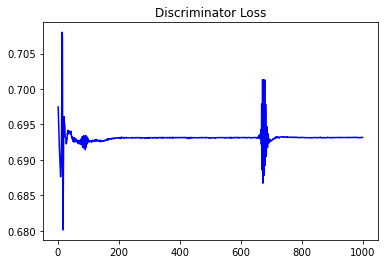

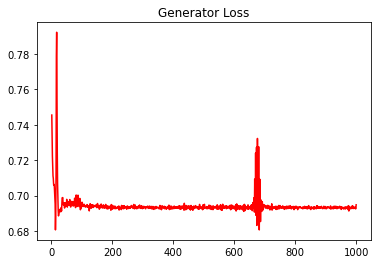

In [12]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [13]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.4650164739228785


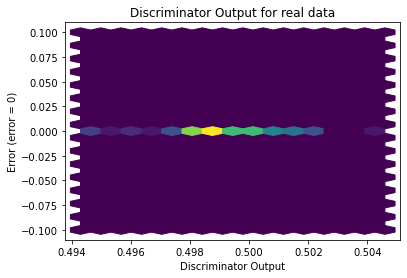

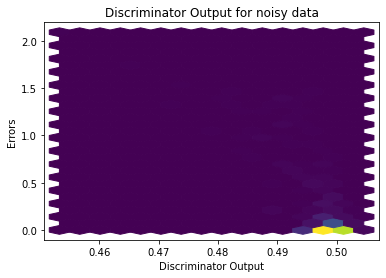

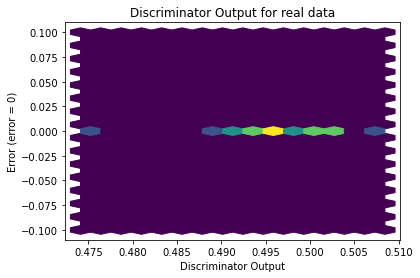

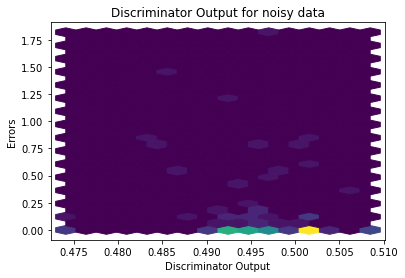

In [14]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Model with TabNet Generator

In [15]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.001, betas=(0.5, 0.999))

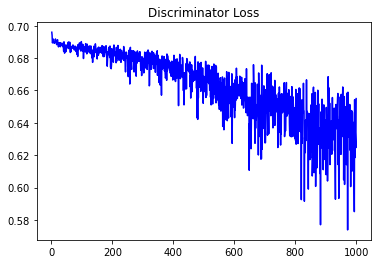

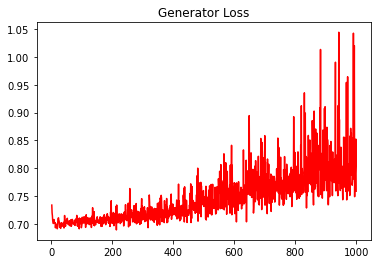

In [16]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc2,gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [17]:
ABC_GAN2_metrics=ABC_train_test2.test_generator(gen2,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)

print("MAE")
print(mean(ABC_GAN2_metrics[1]))

MAE
0.5084204109720886


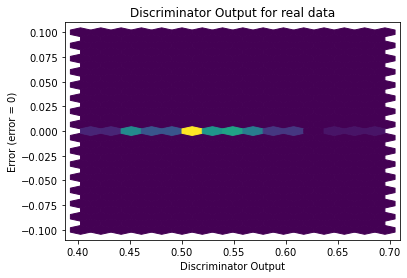

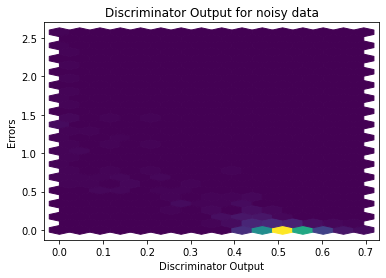

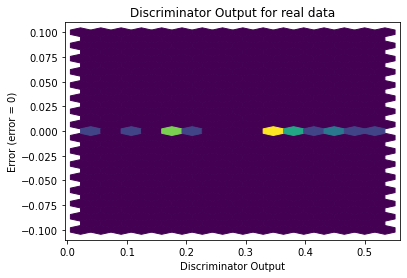

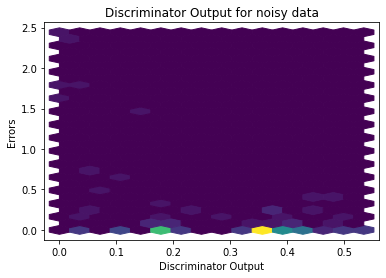

In [18]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skipGAN Model

In [19]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


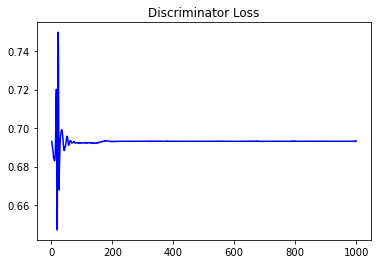

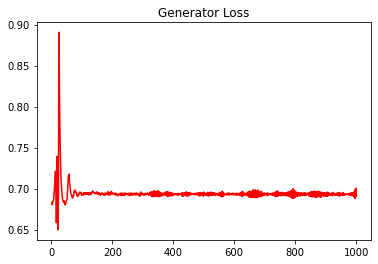

In [20]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [21]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.47932101705577224


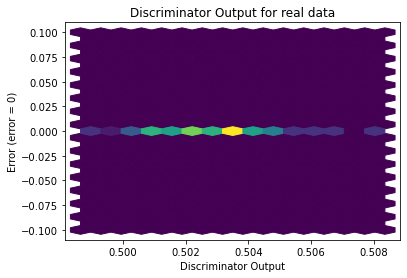

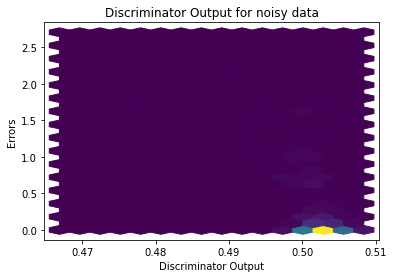

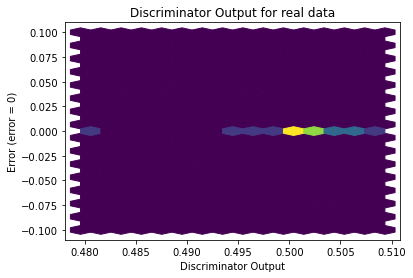

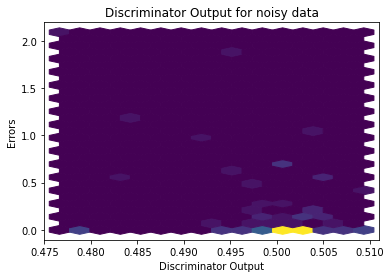

In [22]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skipGAN Model with TabNet Generator

In [23]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.001, betas=(0.5, 0.999))


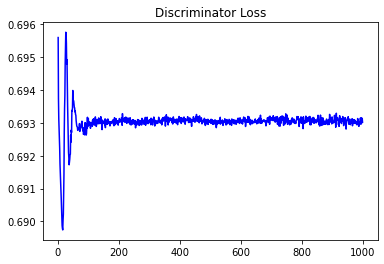

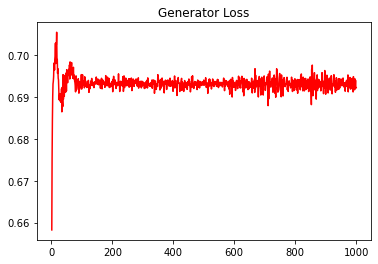

In [24]:
ABC_train_test2.training_GAN_skip_connection(disc4,gen4,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [25]:
ABC_GAN4_metrics=ABC_train_test2.test_generator(gen4,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)

print("MAE")
print(mean(ABC_GAN4_metrics[1]))

MAE
0.46021505375578997


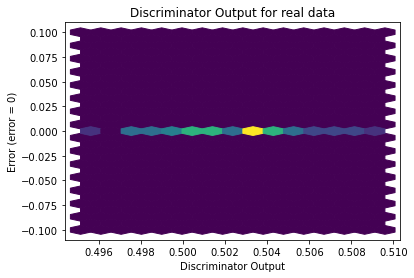

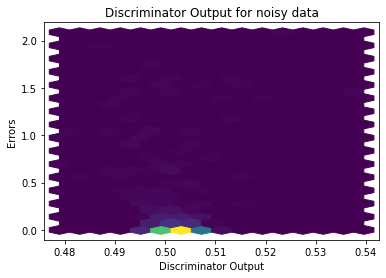

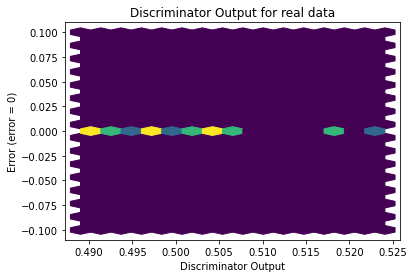

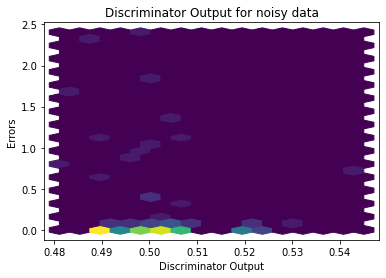

In [26]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [27]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.7268]], requires_grad=True)


## skipGAN Model Analysis (TabNet Generator) 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [28]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0413]], requires_grad=True)
